In [1]:
from pikan.model_utils import GeneralizedMLP, FourierKAN, PirateNet
from pikan.model_utils import get_mse_loss
from pikan.model_utils import KeyHandler, sobol_sample
from pikan.utils import load_dict_from_file, save_dict_to_file

from pikan.interpolated_funcs import circular_wave_interference

import yaml
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
import optax
from functools import partial
from tqdm import tqdm
import pandas as pd

import jax
import pickle
import os

import matplotlib.pyplot as plt

from pikan.pde_utils import get_pde_Helmholtz, get_vanilla_loss, get_adaptive_loss, get_pde_train_step
jax.devices()

[CudaDevice(id=0)]

In [2]:
def sample_collocs(config):
    collocs = jnp.array(sobol_sample(np.array([config["X_MIN"],config["Y_MIN"]]), 
                                     np.array([config["X_MAX"],config["Y_MAX"]]), config["BS"]))
    return collocs

def get_model(config):
    if config["MODEL"] == "MLP":
        return GeneralizedMLP(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            use_fourier_feats=config['FourierFeatures'],
            layer_sizes=config['layers']
        )
    if config["MODEL"] == "KAN":
        return FourierKAN(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            use_fourier_feats=config['FourierFeatures'],
            layer_sizes=config['layers']
        )
    if config["MODEL"] == "PIRATE":
        return PirateNet(
            kernel_init=nn.initializers.glorot_normal(),
            num_input=config['N_INPUT'],
            num_output=1,
            layer_sizes=config['layers'] # first is fourier
        )
    

In [3]:
filename = "PIRATE_HelmHoltz"

with open(f"yaml_configs/{filename}.yaml", 'r') as file:
    config = yaml.safe_load(file)

keygen = KeyHandler(0)
config["experiments"].keys()

experiment = config["experiments"]['increase_params_1']
experiment

{'BS': 16384,
 'BS_BC': 2048,
 'EPOCHS': 10000,
 'FREQ': 10,
 'learnable_func': 'circular_wave_interference',
 'FourierFeatures': True,
 'MODEL': 'PIRATE',
 'layers': [64, 64, 64, 64],
 'N_INPUT': 2,
 'X_MIN': -1,
 'X_MAX': 1,
 'Y_MIN': -1,
 'Y_MAX': 1}

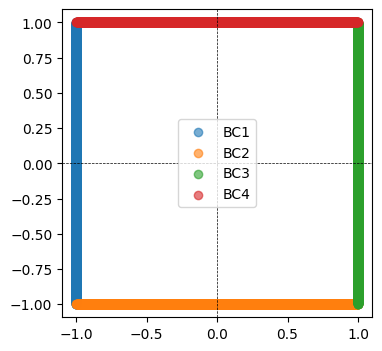

In [4]:
def plot_bc_collocs(bc_collocs):
    """Plots the boundary collocation points."""
    plt.figure(figsize=(4, 4))
    for i, colloc in enumerate(bc_collocs, start=1):
        plt.scatter(colloc[:, 0], colloc[:, 1], label=f'BC{i}', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.legend()
    plt.axis('equal')
    plt.show()
    
# only sample boundary once
BC1_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([-1,1]), experiment["BS_BC"]))
BC1_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)

BC2_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([1,-1]), experiment["BS_BC"]))
BC2_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)

BC3_colloc = jnp.array(sobol_sample(np.array([1,-1]), np.array([1,1]), experiment["BS_BC"]))
BC3_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)

BC4_colloc = jnp.array(sobol_sample(np.array([-1,1]), np.array([1,1]), experiment["BS_BC"]))
BC4_data = jnp.zeros(experiment["BS_BC"]).reshape(-1,1)

bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc, BC4_colloc]
bc_data = [BC1_data, BC2_data, BC3_data, BC4_data]

plot_bc_collocs(bc_collocs)

In [21]:
collocs = sample_collocs(experiment)

N_collocs = collocs.shape[0] + len(bc_collocs) * bc_collocs[0].shape[0]
loc_w = [jnp.ones((collocs.shape[0], 1))] + [jnp.ones((bc_collocs[0].shape[0], 1)) for i in range(len(bc_collocs))]
len(loc_w) # attention weights for collocs and bc are independent

5

In [22]:
model = get_model(experiment)

variables = model.init(keygen.key(), collocs)

# Define a cosine decay learning rate schedule
schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-2,       # Initial learning rate
    decay_steps=experiment["EPOCHS"],  # Total number of decay steps
    alpha=1e-3             # Final learning rate multiplier
)

optimizer = optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
opt_state = optimizer.init(variables['params'])

pde_loss = get_pde_Helmholtz(model)
loss_fn = get_vanilla_loss(model, pde_loss)
train_step = get_pde_train_step(model, optimizer, loss_fn)

In [23]:
state = []
params = variables["params"]

pde_loss(params, collocs, state)

Array([[109.583984  ],
       [ 39.84655   ],
       [156.76941   ],
       ...,
       [ 28.849028  ],
       [  0.34727818],
       [138.55103   ]], dtype=float32)

In [24]:
%%time
grid_adaption = {}

# train always on same colloc points
collocs = sample_collocs(experiment)
state = variables["params"]

losses = []
for i in (pbar:= tqdm(range(experiment["EPOCHS"]))):    
    params = variables["params"]

    params, opt_state, loss, loc_w = train_step(params, collocs, bc_collocs, 
                                                 bc_data, opt_state, state, loc_w)
    variables = {'params': params}
    losses.append(loss)
    
    if i % 50 == 0: # dont waste a lot of time printing
        pbar.set_description(f"Loss {loss: .8f}")

Loss  0.00051080: 100%|███████████████████| 10000/10000 [02:44<00:00, 60.75it/s]

CPU times: user 1min 31s, sys: 1min 4s, total: 2min 36s
Wall time: 2min 44s


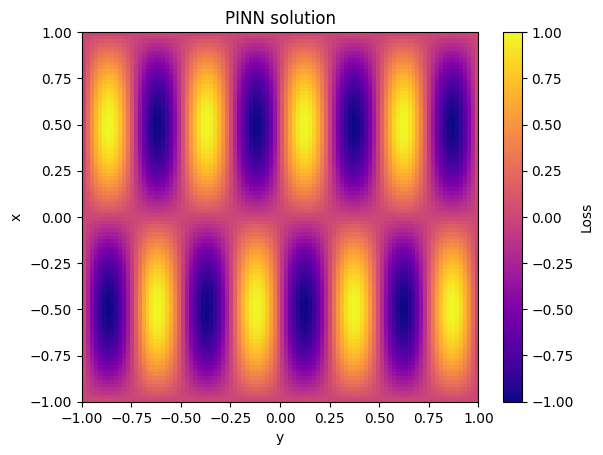

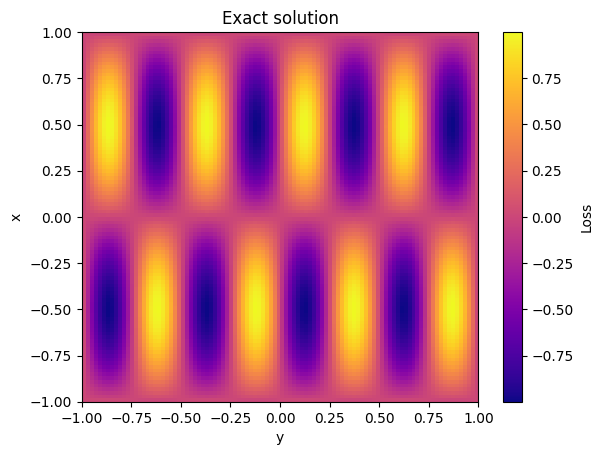

In [25]:
def plot_heatmap(arr, title, experiment):
    # Plot heatmap
    #plt.figure(figsize=(8, 6))
    plt.imshow(arr, extent=(experiment["X_MIN"], experiment["X_MAX"], 
                            experiment["Y_MIN"], experiment["Y_MAX"]), origin="lower", aspect="auto", cmap="plasma")
    plt.colorbar(label="Loss")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.title(title)
    plt.show()

def u(vec_x):
    y = model.apply(variables, vec_x)
    return y

def exact_u(vec_x):
    y = jnp.sin(jnp.pi*vec_x[:, 0])*jnp.sin(4*jnp.pi*vec_x[:, 1])
    return y

def l2_error(results, true):
    err = jnp.sum((results - true)**2) / jnp.sum(true**2)
    err = jnp.sqrt(err)
    return err

N = 100 # NxN grid
x_grid = jnp.linspace(experiment["X_MIN"], experiment["X_MAX"], N)
y_grid = jnp.linspace(experiment["Y_MIN"], experiment["Y_MAX"], N)

# Create a meshgrid of x and t values
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing="ij")
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
grid_points = jnp.stack((x_flat, y_flat), axis=-1)

results = u(grid_points).reshape(N, N)
loss = pde_loss(params, grid_points, state).reshape(N, N)
exact = exact_u(grid_points).reshape(N,N)

plot_heatmap(results,"PINN solution", experiment)
plot_heatmap(exact,"Exact solution", experiment)

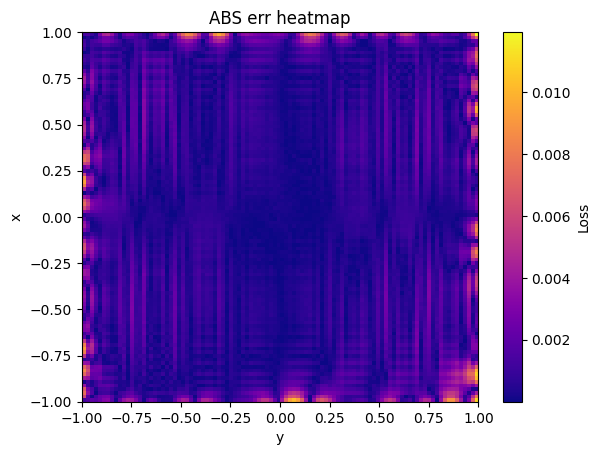

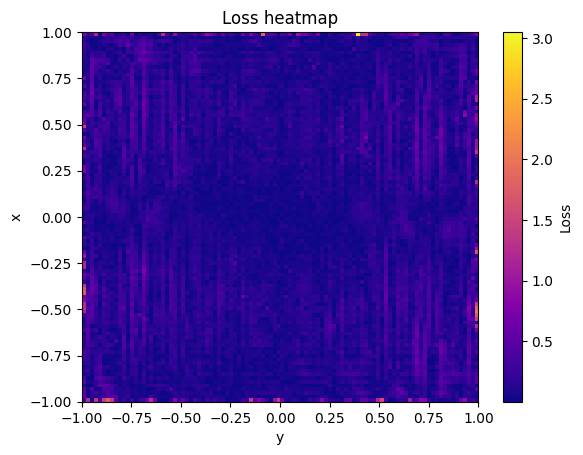

L2 error 0.2926%


Array(0.00292556, dtype=float32)

In [26]:
plot_heatmap(jnp.abs(results - exact),"ABS err heatmap", experiment)
plot_heatmap(jnp.abs(loss),"Loss heatmap", experiment)

l2_err = l2_error(results, exact)
print(f"L2 error {l2_err*100:.4f}%")
l2_err

In [27]:
model

PirateNet(
    # attributes
    kernel_init = init
    num_input = 2
    num_output = 1
    layer_sizes = [64, 64, 64, 64]
)